# Proximal decoding (tensor version) for LDPC-coded AWGN channel and Massive MIMO channel
Written in Pytorch 2.0.0+cu117 (C) Lantian Wei, 2024

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import sys

from pyldpc import coding_matrix
from tqdm import tqdm

print(str(sys.version))
print('pytorch version: ' + str(torch.__version__) )
print('numpy version: ' + str(np.__version__) )

FLOAT_DTYPE = torch.float64
COMPLEX_DTYPE = torch.complex128

np.random.seed(seed=2024)

if torch.cuda.is_available():
    DEVICE = 'cuda'
else:
    DEVICE = 'cpu'
print(DEVICE + ' is used')

ModuleNotFoundError: No module named 'torch'

## Tool methods

In [2]:
def snr_to_var(snr, code_rate, mod_bit=1):
    ''' Eb/N0 to noise variance
    Eb = 1 / (R * BIT)
    no_sigma2 = N0 / 2
    '''
    return 1 / (10 ** (snr / 10) * 2 * code_rate * mod_bit)

def binaryproduct(X, Y):
    A = X @ Y
    return A.real % 2

def read_parity_check_matrix_alist(fname):
    f = open(fname)

    # read the shape
    line = f.readline()
    u = line.split(' ')
    n,m = int(u[0]),int(u[1])

    # read the max column and row weights
    line = f.readline()
    u = line.split(' ')
    # col_max, row_max = int(u[0]),int(u[1])

    # read all column weigth
    line = f.readline()
    u = line.split(' ')
    col_weight_array = np.array(u[:-1]).astype(np.int32)

    # read all row weigth
    line = f.readline()
    u = line.split(' ')
    # row_weight_array = np.array(u[:-1]).astype(np.int32)

    # according to the column weigth array make H
    H = np.zeros((m, n), dtype=np.int32)
    for i in range(n):
        line = f.readline()
        u = line.split('\t')
        for j in range(col_weight_array[i]):
            H[int(u[j])-1][i] = 1

    f.close()
    return H

## Read parity-check matrix and construct the generator matrix

In [3]:
H = read_parity_check_matrix_alist('204.33.484')
Gt = coding_matrix(H)
G = Gt.T
m = H.shape[0]
n = H.shape[1]

# AWGN channel

## Prximal decoder for LDPC-coded AWGN channel

In [4]:
def grad_h(x, H):
    z = torch.log(x)
    zm = torch.log(x - 1)
    zp = torch.log(x + 1)
    w = torch.log((torch.exp(2 * z @ H.T) - torch.exp(z @ H.T)) @ H)
    return 4 * torch.exp(zm+z+zp) + 2 * torch.exp(w - z)

def grad_f_awgn(x, y):
    return x - y

def box_proj(x, eta=1.5):
    x[x.real<-eta] = -eta
    x[x.real>eta] = eta
    return x

def proximal_decoding_awgn(y, H, gamma=0.05, omega=0.05, max_itr=50):
    TH = torch.tensor(H,dtype=COMPLEX_DTYPE).to(DEVICE)
    Ty = torch.tensor(y,dtype=COMPLEX_DTYPE).to(DEVICE)
    s = torch.zeros(TH.shape[1],dtype=COMPLEX_DTYPE).to(DEVICE)
    for _ in range(max_itr):
        r = s - omega * grad_f_awgn(s, Ty)
        s = r - gamma * grad_h(r, TH)
        s = box_proj(s)
    return s

## BP decoer

In [5]:
def BP(LLR, H, max_itr):
    col_weight = H.sum(axis=0)
    row_weight = H.sum(axis=1)
    m = H.shape[0]
    n = H.shape[1]
    weight_list_col = []
    weight_list_row = []
    for i in range(n):
        weight_list_col.append(H[:,i].nonzero()[0])
    for i in range(m):
        weight_list_row.append(H[i,:].nonzero()[0])
    weight_list_col = np.array(weight_list_col, dtype=np.int32)
    weight_list_row = np.array(weight_list_row, dtype=np.int32)

    x_hat = np.zeros(n)
    a = np.zeros((m, n))
    b = np.zeros((m, n))

    for _ in range(max_itr):
        for i in range(n): # variable node operation
            s = 0.0
            for k in range(col_weight[i]):
                s += a[weight_list_col[i,k], i]
            for j in range(col_weight[i]):
                b[weight_list_col[i,j], i] = LLR[i] + s - a[weight_list_col[i,j], i]
            x_hat[i] = s + LLR[i]

        for i in range(m): # check node operation
                prod = 1.0
                for j in range(row_weight[i]):
                    prod *= np.tanh(0.5 * b[i,weight_list_row[i,j]])
                for j in range(row_weight[i]):
                    v = prod / np.tanh(0.5 * b[i,weight_list_row[i,j]])
                    v = min(1.0 - 1e-12, max(-1.0 + 1e-12, v))
                    a[i,weight_list_row[i,j]] = 2.0 * np.arctanh(v)

    return x_hat

## Data generator for AWGN channel

In [6]:
def awgn_test_data_generator(G, snr, batch_size):
    k = G.shape[0]
    n = G.shape[1]
    message = np.random.randint(2,size=(batch_size, k))
    b = binaryproduct(message, G)
    x = (-1)**b
    sigma2 = snr_to_var(snr, k/n, mod_bit=1) # bipolar:bit=1
    no_std = sigma2 ** 0.5
    return x + no_std * np.random.normal(0,1,size=(batch_size, n)), x

## Simulation for AWGN channel

### Proximal decoding

In [7]:
max_test_time = 10
target_block_err = 500
batch_size = 1000

gamma_list = [0.01, 0.05, 0.15]
snr_list = np.arange(1,6,0.5)

ber_map = {}
test_time_map = {}
for gamma in gamma_list:
    ber_log = []
    test_time_log = []
    stop_flag = 0
    for snr in tqdm(snr_list):
        err = 0
        block_err = 0
        for i in range(max_test_time):
            if stop_flag == 1:
                break
            y,x = awgn_test_data_generator(G, snr, batch_size)
            x_hat_soft = proximal_decoding_awgn(y, H, gamma=gamma, max_itr=100).real.cpu().numpy()
            x_hat_hard = np.sign(x_hat_soft)
            err += np.count_nonzero(x_hat_hard-x)
            block_err += np.count_nonzero(np.count_nonzero(x_hat_hard-x, axis=1))
            if block_err > target_block_err:
                break
        if block_err == 0:
            stop_flag = 1
        test_time_log.append(i+1)
        ber_log.append(err / (n * batch_size * (i + 1)))
    ber_map[gamma]=ber_log
    test_time_map[gamma]=test_time_log

100%|██████████| 10/10 [00:03<00:00,  2.71it/s]


### BP decoding

In [8]:
max_test_time = 1000
target_block_err = 100
snr_list = np.arange(1,6,0.5)
bp_ber_log = []
test_time_log = []
stop_flag = 0
for snr in tqdm(snr_list):
    err = 0
    block_err = 0
    y,x = awgn_test_data_generator(G, snr, max_test_time)
    for i in range(max_test_time):
        if stop_flag == 1:
                break
        x_hat = np.sign(BP(2*y[i]/(snr_to_var(snr,0.5)), H, max_itr=30))
        temp_err = np.count_nonzero(x_hat-x[i])
        err += temp_err
        if temp_err > 0:
            block_err += 1
        if block_err > target_block_err:
                break
    if block_err == 0:
        stop_flag = 1
    ber = err/((i+1) * n)
    bp_ber_log.append(ber)
    test_time_log.append(i+1)

100%|██████████| 10/10 [04:54<00:00, 29.41s/it]


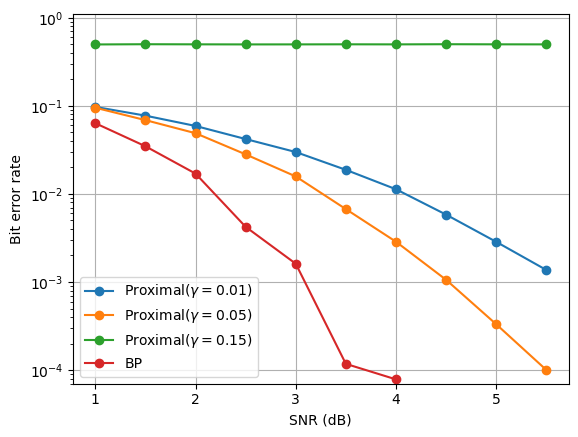

In [9]:
for gamma in gamma_list:
    plt.plot(snr_list, ber_map[gamma], '-o', label="Proximal($\gamma=$"+str(gamma)+")")
plt.plot(snr_list, bp_ber_log, '-o', label="BP")
plt.yscale('log')
plt.ylim(0.00007,1.1)
plt.grid()
plt.legend()
plt.xlabel('SNR (dB)')
plt.ylabel('Bit error rate')
plt.show()

# MIMO channel

## Prximal decoder for LDPC-coded MIMO channel

In [10]:
def grad_f_mimo(x, y, channel_matrix):
    return (x @ channel_matrix.T - y) @ channel_matrix

def proximal_decoding_mimo(y, H, channel_matrix, omega, gamma=0.05, max_itr=1000):
    TH = torch.tensor(H,dtype=COMPLEX_DTYPE).to(DEVICE)
    Ty = torch.tensor(y,dtype=COMPLEX_DTYPE).to(DEVICE)
    TCM = torch.tensor(channel_matrix,dtype=COMPLEX_DTYPE).to(DEVICE)
    s = torch.zeros(TH.shape[1],dtype=COMPLEX_DTYPE).to(DEVICE)
    for _ in range(max_itr):
        r = s - omega * grad_f_mimo(s, Ty, TCM)
        s = r - gamma * grad_h(r, TH)
        s = box_proj(s)
    return s

## MMSE detector

In [11]:
def MMSE_detector(y, snr, channel_matrix):
    size = channel_matrix.shape[0]
    num_snr = 10 ** (snr / 10)
    sigma2 = size / num_snr
    mmse_filter = channel_matrix.T @ np.linalg.inv(channel_matrix @ channel_matrix.T+(sigma2/2)*np.eye(size))
    return y @ mmse_filter.T

## tanh decoder

In [12]:
def tanh_detector(y, channel_matrix, omega, alpha=2, max_itr=50):
    x = np.zeros((y.shape[0], H.shape[1]))
    for i in range(max_itr):
        # x = x - omega * H.T@(H@x - y)
        x = x - omega * (x@channel_matrix.T-y)@channel_matrix
        x = np.tanh(alpha*x)
    return x


## Kronecker_model

In [13]:
def Kronecker_model(rho_tx, rho_rx, n_tx, n_rx):
    R_rx = rho_rx**(torch.arange(n_rx).unsqueeze(1)-torch.arange(n_rx).unsqueeze(0)).abs().numpy()
    R_tx = rho_tx**(torch.arange(n_tx).unsqueeze(1)-torch.arange(n_tx).unsqueeze(0)).abs().numpy()
    Rx = np.linalg.cholesky(R_rx)
    Tx = np.linalg.cholesky(R_tx)
    A = np.sqrt(0.5) * np.random.normal(0,1,size=(n_rx,n_tx)) + 1j*np.sqrt(0.5) * np.random.normal(0,1,size=(n_rx,n_tx))
    H = Rx @ A @ Tx.T
    return H

def paper_chennel_matrix_generator(rho, size):
    A = Kronecker_model(rho,rho,int(size/2),int(size/2))
    return np.block([[A.real, -A.imag],[A.imag, A.real]])

## Data generator for MIMO channel

In [14]:
def mimo_test_data_generator(G, snr, channel_matrix, batch_size):
    k = G.shape[0]
    n = G.shape[1]
    message = np.random.randint(2,size=(batch_size, k))
    b = binaryproduct(message, G)
    x = (-1)**b
    num_snr = 10 ** (snr / 10)
    sigma2 = n / num_snr
    no_std = np.sqrt(sigma2/2)
    y = x @ channel_matrix.T + no_std * np.random.normal(0,1,size=(batch_size, n))
    return y, x

## Simulation for MIMO channel

### Proximal decoding

In [15]:
max_test_time = 20
batch_size = 1000
target_block_err = 200

snr_list = np.arange(5,16,1)
rho_list = [0.0, 0.4]

mimo_ber_map = {}
mimo_test_time_map = {}

for rho in rho_list:
    ber_log = []
    test_time_log = []
    stop_flag = 0
    for snr in tqdm(snr_list):
        err = 0
        block_err = 0
        for i in range(max_test_time):
            if stop_flag == 1:
                break
            channel_matrix = paper_chennel_matrix_generator(rho, n)
            eigv = np.linalg.eigvals(channel_matrix.T.conj()@channel_matrix)
            omega_opt = 2 / (eigv.max()+eigv.min())
            y,x = mimo_test_data_generator(G, snr, channel_matrix, batch_size)
            x_hat_soft = proximal_decoding_mimo(y, H, channel_matrix, omega_opt, max_itr=50).real.cpu().numpy()
            x_hat_hard = np.sign(x_hat_soft)
            err += np.count_nonzero(x_hat_hard-x)
            block_err += np.count_nonzero(np.count_nonzero(x_hat_hard-x, axis=1))
            if block_err > target_block_err:
                break
        if block_err == 0:
            stop_flag = 1
        test_time_log.append(i+1)
        ber_log.append(err / (n * batch_size * (i + 1)))
    mimo_ber_map[rho]=ber_log
    mimo_test_time_map[rho]=test_time_log

100%|██████████| 11/11 [00:24<00:00,  2.24s/it]


### MMSE detection

In [16]:
max_test_time = 20
batch_size = 1000
target_block_err = 200

snr_list = np.arange(5,16,1)
rho_list = [0.0, 0.4]

mmse_mimo_ber_map = {}
mmse_mimo_test_time_map = {}

for rho in rho_list:
    ber_log = []
    test_time_log =[]
    stop_flag = 0
    for snr in tqdm(snr_list):
        err = 0
        block_err = 0
        for i in range(max_test_time):
            if stop_flag == 1:
                break
            channel_matrix = paper_chennel_matrix_generator(rho, n)
            y,x = mimo_test_data_generator(G, snr, channel_matrix, batch_size)
            x_hat_soft = MMSE_detector(y, snr, channel_matrix)
            x_hat_hard = np.sign(x_hat_soft)
            err += np.count_nonzero(x_hat_hard-x)
            block_err += np.count_nonzero(np.count_nonzero(x_hat_hard-x, axis=1))
            if block_err > target_block_err:
                break
        if block_err == 0:
            stop_flag = 1
        test_time_log.append(i+1)
        ber_log.append(err / (n * batch_size * (i + 1)))
    mmse_mimo_ber_map[rho]=ber_log
    mmse_mimo_test_time_map[rho]=test_time_log

100%|██████████| 11/11 [00:00<00:00, 54.12it/s]


### MMSE+BP

In [17]:
max_test_time = 1000
target_block_err = 100

batch_size = 1
snr_list = np.arange(5,16,1)
rho_list = [0.0, 0.4]

mmsebp_mimo_ber_map = {}
mmsebp_mimo_test_time_map = {}

for rho in rho_list:

    ber_log = []
    test_time_log =[]
    stop_flag = 0
    for snr in tqdm(snr_list):
        err = 0
        block_err = 0
        for i in range(max_test_time):
            if stop_flag == 1:
                break
            channel_matrix = paper_chennel_matrix_generator(rho, n)
            y,x = mimo_test_data_generator(G, snr, channel_matrix, batch_size)
            x_hat_mmse = MMSE_detector(y, snr, channel_matrix)[0]
            x_hat = np.sign(BP(x_hat_mmse*5, H, max_itr=20))
            err += np.count_nonzero(x_hat-x)
            block_err += np.count_nonzero(np.count_nonzero(x_hat-x, axis=1))
            if block_err > target_block_err:
                break
        if block_err == 0:
            stop_flag = 1
        test_time_log.append(i+1)
        ber_log.append(err / (n * batch_size * (i + 1)))
    mmsebp_mimo_ber_map[rho]=ber_log
    mmsebp_mimo_test_time_map[rho]=test_time_log

100%|██████████| 11/11 [03:35<00:00, 19.58s/it]


### tanh detection

In [18]:
max_test_time = 20
batch_size = 1000
target_block_err = 200

snr_list = np.arange(5,16,1)
rho_list = [0.0, 0.4]

tanh_mimo_ber_map = {}
tanh_mimo_test_time_map = {}

for rho in rho_list:
    ber_log = []
    test_time_log =[]
    stop_flag = 0
    for snr in tqdm(snr_list):
        err = 0
        block_err = 0
        for i in range(max_test_time):
            if stop_flag == 1:
                break
            channel_matrix = paper_chennel_matrix_generator(rho, n)
            eigv = np.linalg.eigvals(channel_matrix.T.conj()@channel_matrix)
            omega_opt = 2 / (eigv.max()+eigv.min())
            y,x = mimo_test_data_generator(G, snr, channel_matrix, batch_size)
            x_hat_soft = tanh_detector(y, channel_matrix, omega_opt, max_itr=50)
            x_hat_hard = np.sign(x_hat_soft)
            err += np.count_nonzero(x_hat_hard-x)
            block_err += np.count_nonzero(np.count_nonzero(x_hat_hard-x, axis=1))
            if block_err > target_block_err:
                break
        if block_err == 0:
            stop_flag = 1
        test_time_log.append(i+1)
        ber_log.append(err / (n * batch_size * (i + 1)))
    tanh_mimo_ber_map[rho]=ber_log
    tanh_mimo_test_time_map[rho]=test_time_log

100%|██████████| 11/11 [00:04<00:00,  2.27it/s]


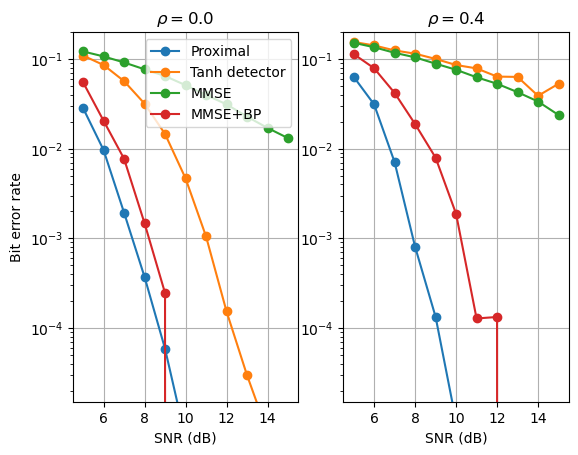

In [19]:
i = 0
for rho in rho_list:
    i += 1
    plt.subplot(1,2,i)
    plt.plot(snr_list, mimo_ber_map[rho], "-o", label='Proximal')
    plt.plot(snr_list, tanh_mimo_ber_map[rho], "-o", label='Tanh detector')
    plt.plot(snr_list, mmse_mimo_ber_map[rho], "-o", label='MMSE')
    plt.plot(snr_list, mmsebp_mimo_ber_map[rho], "-o", label='MMSE+BP')
    plt.yscale('log')
    plt.ylim( 0.000015,0.2)
    plt.xticks(np.arange(6,15,2))
    plt.grid()
    plt.xlabel("SNR (dB)")
    plt.title('$\\rho=$' + str(rho))
plt.subplot(1,2,1)
plt.ylabel('Bit error rate')
plt.legend(loc=1)
plt.show()

# Simulated BER result

In [20]:
def print_map(m):
    for key in m.keys():
        print(m[key])

## Proximal decoding

In [21]:
print("Proximal decoding for AWGN channel:")
print_map(ber_map)
print("Proximal decoding for MIMO channel:")
print_map(mimo_ber_map)

Proximal decoding for AWGN channel:
[0.09725980392156863, 0.07738725490196079, 0.05911764705882353, 0.04199019607843137, 0.029897058823529412, 0.01877450980392157, 0.01130392156862745, 0.005823529411764706, 0.002860294117647059, 0.0013709150326797386]
[0.09518137254901961, 0.06884803921568627, 0.048901960784313726, 0.02813235294117647, 0.015794117647058823, 0.006727124183006536, 0.0028676470588235295, 0.0010602941176470588, 0.0003318627450980392, 0.00010049019607843137]
[0.4977401960784314, 0.5006960784313725, 0.4992892156862745, 0.49827941176470586, 0.4986127450980392, 0.49962254901960784, 0.49873039215686277, 0.5008137254901961, 0.4994019607843137, 0.49866666666666665]
Proximal decoding for MIMO channel:
[0.028436274509803922, 0.00967156862745098, 0.0019362745098039215, 0.0003713235294117647, 5.8565531475748196e-05, 5.882352941176471e-06, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.06362254901960784, 0.031230392156862744, 0.007088235294117647, 0.0008050108932461874, 0.00013308823529411764, 9.0686274

## others

In [22]:
print("BP for AWGN channel:")
print(bp_ber_log)
print("tanh for MIMO channel:")
print_map(tanh_mimo_ber_map)
print("MMSE for MIMO channel:")
print_map(mmse_mimo_ber_map)
print("MMSE+BP for MIMO channel:")
print_map(mmsebp_mimo_ber_map)

BP for AWGN channel:
[0.06350693143499438, 0.03475600766622439, 0.01700486396108831, 0.004230392156862745, 0.0016127450980392157, 0.00011764705882352942, 7.843137254901961e-05, 0.0, 0.0, 0.0]
tanh for MIMO channel:
[0.10952450980392157, 0.08587745098039215, 0.056808823529411766, 0.03185294117647059, 0.014602941176470588, 0.00467156862745098, 0.0010514705882352941, 0.00015305010893246188, 2.9656862745098038e-05, 6.862745098039215e-06, 2.4509803921568627e-07]
[0.15522549019607843, 0.14215686274509803, 0.1249607843137255, 0.1149264705882353, 0.10041666666666667, 0.08589705882352941, 0.07875980392156863, 0.0637892156862745, 0.06326470588235295, 0.03892647058823529, 0.05307352941176471]
MMSE for MIMO channel:
[0.12168627450980392, 0.10717156862745097, 0.09172058823529412, 0.07691176470588235, 0.06469117647058824, 0.051176470588235295, 0.039799019607843135, 0.03127450980392157, 0.022799019607843137, 0.01705392156862745, 0.013122549019607844]
[0.15218137254901962, 0.13561764705882354, 0.11756